# To get started look at the Getting Started links in our [wiki](https://github.com/bytebarista/iot_workshop/wiki):


### When setup and connected to your device
Open your serial terminal and run all the code cells in this notebook there to make it run on the device.

#### To copy-paste multiple lines of text to the terminal in one go:
You first have to enter "bulk paste mode", **ctrl + e**, and from there the method for pasting depends on how you set up the connection.

Regardless, when you are done with bulk pasting; finish with **ctrl + d** which will exit and execute the code snippets.

#### IMPORTANT: While not in bulk-paste mode **ctrl + d** soft reboots the device!

# General-purpose Input/Output ([GPIO](https://en.wikipedia.org/wiki/General-purpose_input/output))

### Turn your controller over and on the back you'll find the microcontroller

On it there's a tiny green LED. It should be on. Let's turn it off. Also check out
the [Pin](https://docs.micropython.org/en/latest/esp32/quickref.html#pins-and-gpio) and gpio classes

In [ ]:
from machine import Pin

pin_onboard_led = 19
p = Pin(pin_onboard_led, Pin.OUT)
p.off()

If you wan't to turn it back on just write **p.on()** in the interactive session

## Let's specify the Pulse With Modulation ([PWM](https://docs.micropython.org/en/latest/esp32/quickref.html#pwm-pulse-width-modulation)) settings to dim that LED

In [ ]:
from machine import Pin, PWM

pwm0 = PWM(Pin(19))       
pwm0.freq(100)     
pwm0.duty(20)

##### Try, for example, changing the frequency to 5
You can also try setting the frequency up again, but the duty down to 5.

PWM is a technique used to emulate an analog signal, as such:
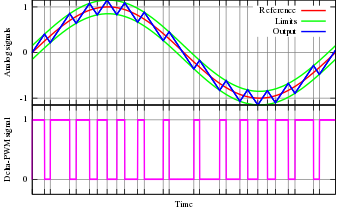
https://en.wikipedia.org/wiki/Pulse-width_modulation

Reset the LED light by running: **pwm0.deinit()**

### Turn your controller back over again!

Let's try some addressable RGB-LEDs by running a [show](https://github.com/bytebarista/iot_workshop/blob/master/src/led_show.py)!

There are four LEDs on the right side of the display, running vertically up from the *LEDS* tag on the controller.

The cell below runs for a long time, interrupt it as usual by a quick **ctrl + c** in the interactive session. You'll notice how they get "stuck in place" as there is no shutdown signal attached to the *KeyboardInterruptException*.

In [ ]:
import led_show

led_show.run()

If you are curious about the inner workings on these LEDs you can find the datasheet [here](https://cdn-shop.adafruit.com/datasheets/APA102.pdf) and the singal source code [here](https://github.com/bytebarista/iot_workshop/blob/master/src/led_lights.py)

### Serial Peripheral Interface ([SPI](https://en.wikipedia.org/wiki/Serial_Peripheral_Interface))

For communication between components there are two major protocols worth mentioning: SPI, and [P2C](https://en.wikipedia.org/wiki/I%C2%B2C)

The following controller components are communicating over SPI:
* The main [display](https://cdn-shop.adafruit.com/datasheets/ILI9341.pdf)
* The microSD card reader

The following components are communicating over I2C:
* [GPIO-extender](https://www.microchip.com/wwwproducts/en/MCP23017)
* [BME280](https://www.bosch-sensortec.com/bst/products/all_products/bme280)
* [MPU9250](https://www.invensense.com/products/motion-tracking/9-axis/mpu-9250/) 9-axis motion sensor
* [display touch driver](https://www.crystalfontz.com/controllers/FocalTech/FT6336G/)

Let's instantiate an SPI object

[argument explanation](https://docs.micropython.org/en/latest/esp32/quickref.html#hardware-spi-bus)

In [ ]:
from machine import Pin, SPI

spi = SPI(2, 40000000, miso=Pin(19), mosi=Pin(23), sck=Pin(18))

## Given that you have a microSD card on the controller
You can first mount it:


In [ ]:
import os
from sdcard import SDCard

sd = SDCard(spi, cs=Pin(14))

os.mount(sd, '/sd')

And confirm that it was mounted:

(you should find a folder called 'sd' in the output)

In [ ]:
os.listdir('/')

Let's create and write to a file on the SD card and read back from it:

In [ ]:
with open('/sd/test.txt', 'w') as f:
    f.write("Hello World!")

with open('/sd/test.txt', 'r') as f:
    print(f.read())

## The Display ([official](https://github.com/jeffmer/micropython-ili9341), [loboris](https://github.com/loboris/MicroPython_ESP32_psRAM_LoBo/wiki/display))

example 1

In [ ]:
from ili934xnew import ILI9341, color565
from machine import SPI, Pin

display = ILI9341(spi,
    cs=Pin(0),
    dc=Pin(15),
    rst=Pin(5))
display.erase()
display.set_pos(0,0)
display.width = 240
display.height = 320

display.fill_rectangle(0, 0, 239, 319, color565(180,114,52))
display.fill_rectangle(0, 0, 239, 319, color565(80,184,152))
display.fill_rectangle(0, 0, 239, 319, color565(45,114,252))

example 2

In [ ]:
import time, random

width = 240
height = 320

screen_x_mid = int(width/2)
screen_y_mid = int(height/2)

UL_square = [0,0, screen_x_mid,screen_y_mid]
UR_square = [screen_x_mid,0, width,screen_y_mid]
LR_square = [screen_x_mid,screen_y_mid, width,height]
LL_square = [0,screen_y_mid, screen_x_mid,height]

squares = [UL_square, UR_square, LR_square, LL_square]

while True:
    try:
        r, g, b = random.randint(40, 225), random.randint(40, 225), random.randint(40, 225)
        fillcolor = color565(r, g, b)
        x, y, x1, y1 = squares[random.randint(0, 3)]
        display.fill_rectangle(x, y, x1, y1, fillcolor)
        time.sleep(0.12)
    except KeyboardInterrupt:
        for s in squares:
            x, y, x1, y1 = s
            display.fill_rectangle(x, y, x1, y1, color565(40,40,40))
        display.fill_rectangle(0, 0, width, height, color565(30,30,40))
        display.fill_rectangle(0, 0, width, height, color565(20,30,20))
        display.fill_rectangle(0, 0, width, height, color565(20,10,10))
        display.fill_rectangle(0, 0, width, height, color565(0,0,0))
        break
        

## The Speaker

Makes a quick buzzzzzzz

In [ ]:
from machine import DAC, Pin
import math
import time

sh = Pin(2, Pin.OUT, Pin.PULL_UP)
sh.value(1)

dac = DAC(Pin(26))

# create a buffer containing a sine-wave
buf = bytearray(100)
for i in range(len(buf)):
    buf[i] = 128 + int(127 * math.sin(2 * math.pi * i / len(buf)))

bl = len(buf)
for i in range(9999999):
    dac.write(buf[i % bl])

# Larger input-to-display examples

### The Sensors [source](https://github.com/bytebarista/iot_workshop/blob/master/src/temp.py)
Uses The display to show readings from several of the sensors mounted on the controller.

In [ ]:
import temp  # for temperature, not "temp file" O:)

temp.run()

### The Games 
Pac-main [source](https://github.com/bytebarista/iot_workshop/blob/master/src/pac.py)
Shows the responsivness of the pad-input-to-display-update when it's configured with area buffer.

In [ ]:
import pac

pac.main()

Tetrix [source](https://github.com/bytebarista/iot_workshop/blob/master/src/tetrix.py)
Builds on pac-main to include the buttons and a more complete gaming experience.

In [ ]:
import tetrix

tetrix.run()

# Open task suggestions for you

* **The thumbslide** has many a quirk, and is not exemplified anywhere in this notebook. It has a dynamic range of "at rest" values for both x and y, which is not necessarily the same ranges. [ready-made thumbslide source](https://github.com/bytebarista/iot_workshop/blob/master/src/thumbslide.py)
  * You could make code to determine the state of the thumbslide to either be moved or not.
  * And/or you could calculate the angle it is held at *given* that it is moved.
  * You can switch out the check for "PAD_DOWN_PRESSED" in the tetrix game with an angle check for the thumbslide.
  * Or, switch out the whole pad control for pac-main with the thumbslide.
* **The Speaker** can do a little bit more than just buzzzz uncomfortably.
  * The boot sequence could make a "boot complete" audio(-visual?) signal on completion.
  * The inputs could make different beeps on press ([note frequencies](http://pages.mtu.edu/~suits/notefreqs.html))
  * Pac-main and Tetrix are both silent gaming experiences, they could make use of some beeps and plings and buzzzzzes.
  * The sound could make use of a simple Low Frequency Oscillator ([LFO](https://en.wikipedia.org/wiki/Low-frequency_oscillation)) add-on to the example to give it a bit more "emotional range".
  